# Skin Lesion Classification: Cancer or Not?
**By: Sameeha Ramadhan**

In [1]:
#importing same packages as my last project
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette("flare", as_cmap=True)

from keras.preprocessing import image
from keras.models import Model, Sequential
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

#!pip install efficientnet <---installed

import efficientnet.keras as efn
from keras.applications.resnet50 import ResNet50
from keras import regularizers 
from keras.regularizers import l2

import keras
import keras.backend
from IPython.display import display

import cv2


from skimage.io import imread
from skimage.transform import resize
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

np.random.seed(20)

In [16]:
main_dir = 'C:\\Users\\15164\\Desktop\\data\\'
data_directory = os.listdir('C:\\Users\\15164\\Desktop\\data\\')
print(data_directory)

['test', 'train']


In [17]:
for _set in ['test', 'train']:
    x_benign = len(os.listdir(main_dir + _set + '/benign'))
    x_malignant = len(os.listdir(main_dir + _set + '/malignant'))
    print('Set: {}, Benign Images: {}, Malignant Images: {}, Total: {}'.format(_set, x_benign,
                                                                                x_malignant, (x_benign + x_malignant)))

Set: test, Benign Images: 360, Malignant Images: 300, Total: 660
Set: train, Benign Images: 1440, Malignant Images: 1197, Total: 2637


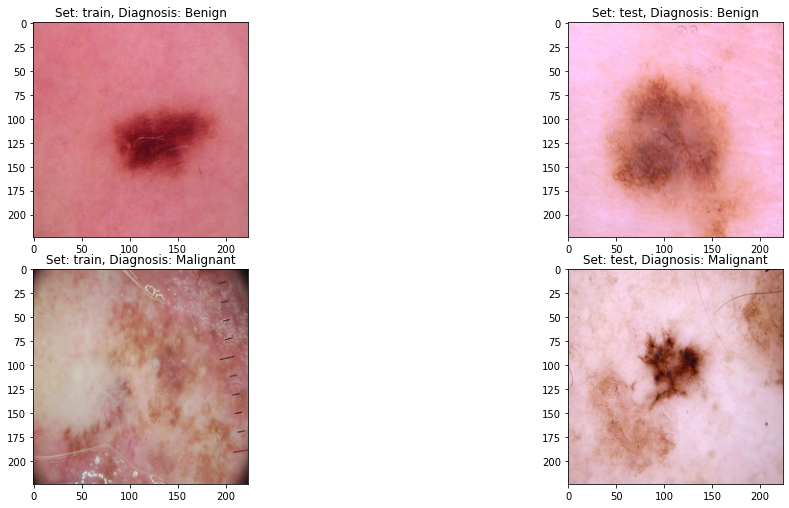

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = main_dir+_set
    ax[i].imshow(plt.imread(set_path+'/benign/'+os.listdir(set_path+'/benign')[1]), cmap='gist_gray')
    ax[i].set_title('Set: {}, Diagnosis: Benign'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/malignant/'+os.listdir(set_path+'/malignant')[1]), cmap='gist_gray')
    ax[i+2].set_title('Set: {}, Diagnosis: Malignant'.format(_set))

# Checking Data Balance:

In [19]:
train_dir = os.path.join(main_dir, "train\\")
test_dir = os.path.join(main_dir, "test\\")

In [20]:
#Train data:
train_df = []

benign_set = os.path.join(train_dir,'benign')
malignant_set = os.path.join(train_dir,'malignant')

#Image list:

benign_images = glob(benign_set+"/*.jpg") + glob(benign_set+"/*.jpeg") + glob(benign_set+"/*.png")
malignant_images = glob(malignant_set + "/*.jpg") + glob(malignant_set + "/*.jpeg") + glob(malignant_set + "/*.png")

#Benign scans are labeled 0:
for img in benign_images:
    train_df.append((img, 0))

#Malignant are labeled 1:
for img in malignant_images:
    train_df.append((img, 1))

#Creating a dataframe:
train_df = pd.DataFrame(train_df, columns=['Image', 'Diagnosis'], index=None)

In [21]:
#Test data:
test_df = []

benign_set = os.path.join(test_dir,'benign')
malignant_set = os.path.join(test_dir,'malignant')

#Image list:
benign_images = glob(benign_set+"/*.jpg") + glob(benign_set+"/*.jpeg") + glob(benign_set+"/*.png")
malignant_images = glob(malignant_set + "/*.jpg") + glob(malignant_set + "/*.jpeg") + glob(malignant_set + "/*.png")

#Benign scans are labeled 0:
for img in benign_images:
    test_df.append((img, 0))

#Malignant are labeled 1:
for img in malignant_images:
    test_df.append((img, 1))

#Create the dataframe:
test_df = pd.DataFrame(test_df, columns=['Image', 'Diagnosis'], index=None)

## Plotting Binary Data:

In [22]:
def balance_check(data):
#'data': the dfs we've created
    image_count = data['Diagnosis'].value_counts()
    print('Counts:')
    print(image_count)
    
    plt.figure(figsize=(11,7))
    sns.barplot(x= image_count.index, y= image_count.values)
    plt.title('Plot of Diagnosis Balancing', fontsize= 14)
    plt.xlabel('Diagnosis', fontsize= 11)
    plt.ylabel('Image Count', fontsize= 11)
    plt.xticks(range(len(image_count.index)), ['Benign(0)', 'Malignant(1)'])
    plt.show()

In [23]:
train_df['Diagnosis'].value_counts()

0    1440
1    1197
Name: Diagnosis, dtype: int64

Counts:
0    1440
1    1197
Name: Diagnosis, dtype: int64


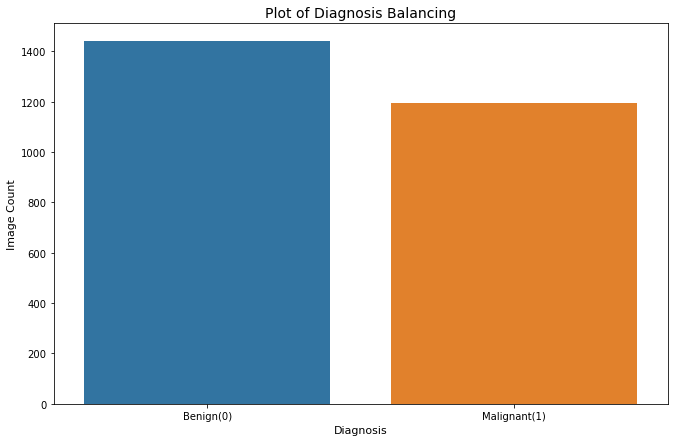

In [24]:
balance_check(train_df)

Counts:
0    360
1    300
Name: Diagnosis, dtype: int64


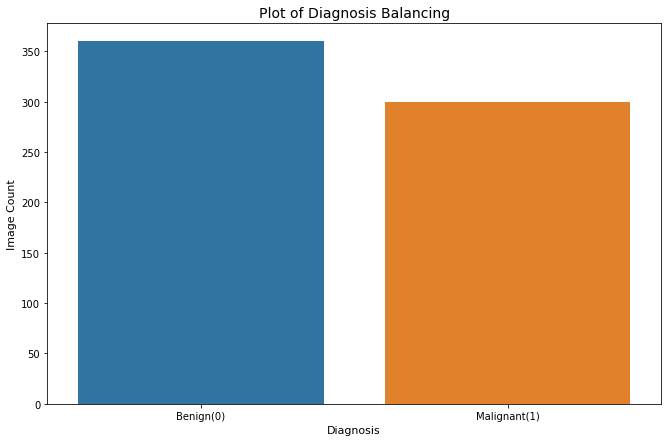

In [25]:
balance_check(test_df)

## Image Augmentation

In [26]:
def data_processing(img_dims, batch_size):
    train_data_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_data_gen = ImageDataGenerator(rescale=1./255) #scaling the images to the same range [0,1]
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_generator = train_data_gen.flow_from_directory(
    directory=train_dir, 
    target_size=(img_dims, img_dims),  #Each image will be resized to this size
    batch_size=batch_size, #number of observations that are inputted into the model at one time
    class_mode='binary', 
    shuffle=True)

    test_generator = test_data_gen.flow_from_directory(
    directory=test_dir, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=False)
    
    # In order to plot the Confusion Matrix, I will be making predictions off of the test set in one batch size
    test_data = []
    test_labels = []

    for cond in ['/benign/', '/malignant/']:
        for img in (os.listdir(main_dir + 'test' + cond)):
            img = plt.imread(main_dir+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/benign/':
                label = 0
            elif cond=='/malignant/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_generator, test_generator, test_data, test_labels

In [27]:
import cv2
#Values for later use:
img_dims = 150
epochs = 30
batch_size = 10
train_generator, test_generator, test_data, test_labels = data_processing(img_dims, batch_size)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


### Model Visualization Function:

In [28]:
def model_performance(history):
    
    history_dict = history.history
    train_loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']#<--'val' here is for validation, and will be from the 'test' dataset
    train_accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(8,8))
    
    #Plotting loss results:    
    epochs = range(1, len(val_loss_values) + 1) #epoch: the number of times the model will be fit on the training set.
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=train_loss_values, label='Train Loss')
    
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=val_loss_values, label='Val Loss')
    plot1.set(xlabel='Epochs', ylabel='Loss')
    plot1.axes.set_title('Model Loss', fontsize=18)
    plot1.grid(b=True, which='major', axis='y') #To show the grid lines or not
    
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=train_accuracy, label='Train Accuracy')
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=val_accuracy, label='Val Accuracy')
    plot2.set(xlabel='Epochs', ylabel='Accuracy')
    plot2.axes.set_title('Model Accuracy', fontsize=20)
    plot2.grid(b=True, which='major', axis='y')
    
    plt.tight_layout()
    plt.show()

# Model 1: CNN 

In [29]:
inputs = Input(shape=(img_dims, img_dims, 3))

#1st Convolution
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#2nd Convolution
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#3rd Convolution
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#4th Convolution
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#5th Convolution
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fully Connected layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x) #<--Converting a real value into a interpretable probability

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
#hdf5 (Hierarchical Data Format) is to store the weights of the best performing epoch
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max') #<--Reduce learning rate 
#when the metric has stopped improving.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [30]:
hist = model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, 
           epochs=epochs, validation_data=test_generator, shuffle=True,
           validation_steps=test_generator.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/30
263/263 [==============================] - 81s 309ms/step - loss: 0.5759 - accuracy: 0.7141 - val_loss: 0.7167 - val_accuracy: 0.4545
Epoch 2/30
263/263 [==============================] - 82s 311ms/step - loss: 0.4741 - accuracy: 0.7826 - val_loss: 1.0161 - val_accuracy: 0.5455
Epoch 3/30
263/263 [==============================] - 75s 285ms/step - loss: 0.4702 - accuracy: 0.7903 - val_loss: 0.5226 - val_accuracy: 0.7015
Epoch 4/30
263/263 [==============================] - 78s 297ms/step - loss: 0.4523 - accuracy: 0.7868 - val_loss: 1.3085 - val_accuracy: 0.6258
Epoch 5/30
263/263 [==============================] - 73s 276ms/step - loss: 0.4458 - accuracy: 0.7914 - val_loss: 0.4263 - val_accuracy: 0.8030
Epoch 6/30
263/263 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.8032
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
263/263 [==============================] - 72s 275ms/step - loss: 0.4468 - accuracy: 0.8032 - val_l

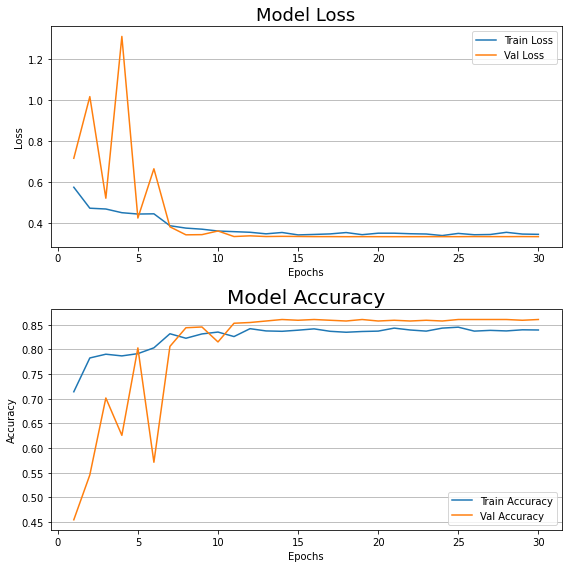

In [31]:
model_performance(hist)

In [32]:
preds = model.predict(test_generator)

accur = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()
#tp = true positive tn = true negative fp = false positive fn = false negative


print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accur))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train Accuracy: {}'.format(np.round((hist.history["accuracy"][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[298  62]
 [ 30 270]]

TEST METRICS ----------------------
Accuracy: 86.06060606060606%
Precision: 81.32530120481928%
Recall: 90.0%
F1-score: 85.44303797468355

TRAIN METRIC ----------------------
Train Accuracy: 83.94


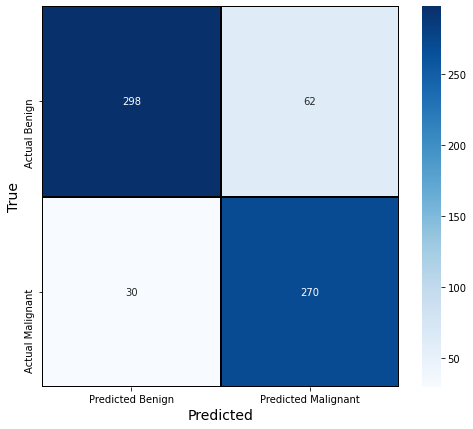

In [33]:
cm = pd.DataFrame(cm, index = ['Actual Benign', 'Actual Malignant'], columns = ['Predicted Benign', 'Predicted Malignant'])
plt.figure(figsize = (8,7))
labels = ['Benign', 'Malignant']
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()


# Model 2:

In [24]:
#To free up memory space:
tf.keras.backend.clear_session()

In [107]:
s = 20
np.random.seed(s)
tf.random.set_seed(s)

In [108]:
def resize_images(directory, resize):
    images = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for image_name in os.listdir(directory):
        PATH = os.path.join(directory, image_name)
        _, ftype = os.path.splitext(PATH)
        if ftype.endswith((".jpg", ".jpeg", ".png")):
            img = read(PATH)
            img = cv2.resize(img, (resize, resize))
            images.append(np.array(img)/255.)
    return images

In [109]:
benign_train = np.array(resize_images('C:\\Users\\15164\\Desktop\\data\\train\\benign', 224))

In [110]:
malign_train = np.array(resize_images('C:\\Users\\15164\\Desktop\\data\\train\\malignant', 224))

In [111]:
benign_test = np.array(resize_images('C:\\Users\\15164\\Desktop\\data\\test\\benign', 224))

In [112]:
malign_test = np.array(resize_images('C:\\Users\\15164\\Desktop\\data\\train\\malignant', 224))

In [113]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merging
x_train = np.concatenate((benign_train, malign_train), axis = 0)
y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
x_test = np.concatenate((benign_test, malign_test), axis = 0)
y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [114]:
# Shuffling train data
sh = np.arange(x_train.shape[0])
np.random.shuffle(sh)
x_train = x_train[sh]
y_train = y_train[sh]

# Shuffling test data
sh = np.arange(x_test.shape[0])
np.random.shuffle(sh)
x_test = x_test[sh]
y_test = y_test[sh]

In [115]:
# Splitting validation set from train set
#x_train=x_train[500:]
#x_val=x_train[:500]
#y_train=y_train[500:]
#y_val=y_train[:500]

In [116]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=s)

In [117]:
x_test.shape, x_val.shape, x_train.shape #<---Checking the code's success:

((1557, 224, 224, 3), (528, 224, 224, 3), (2109, 224, 224, 3))

In [118]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)
y_val = to_categorical(y_val, num_classes= 2)

In [119]:
# normalization 
x_train = x_train/255.
x_test = x_test/255.
x_val = x_val/255.

#Rechecking shape:
x_test.shape,  x_train.shape, x_val.shape,

((1557, 224, 224, 3), (2109, 224, 224, 3), (528, 224, 224, 3))

In [120]:
datagen = ImageDataGenerator(rotation_range=45, zoom_range = 0.1, width_shift_range=0.2, height_shift_range=0.2, 
                             horizontal_flip=True, vertical_flip=True)

In [121]:
eff_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model2=Sequential()
model2.add(eff_net)
model2.add(layers.GlobalAveragePooling2D())
model2.add(Dense(128, activation='relu'))
#model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(2, activation='softmax'))

alpha = 1e-3
for layer in model2.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))


model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               163968    
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total params: 4,214,302
Trainable params: 4,172,030
Non-trainable params: 42,272
_________________________________________________________________


In [122]:
#lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, mode='max')

reduce_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=0, mode='max', min_delta=0.0001,
                             cooldown=0, min_lr=0)

checkpoint = ModelCheckpoint(filepath='best_weights2.hdf5', save_best_only=True, save_weights_only=True)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=20, mode='min', verbose = 1)

optimizer= Adam(lr=0.0001)

In [123]:
# Shuffling train data again
sh = np.arange(x_train.shape[0])
np.random.shuffle(sh)
x_train = x_train[sh]
y_train = y_train[sh]

# Shuffling test data
#sh = np.arange(x_test.shape[0])
#np.random.shuffle(sh)
#x_test = x_test[sh]
#y_test = y_test[sh]

# Shuffling validation data to avoid overfitting the model:
sh = np.arange(x_val.shape[0])
np.random.shuffle(sh)
x_val = x_val[sh]
y_val = y_val[sh]

In [124]:
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
hist = model2.fit(datagen.flow(x_train, y_train, batch_size=10), epochs=20, steps_per_epoch= 200,
                  validation_data=(x_val, y_val),callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/20
200/200 [==============================] - 392s 2s/step - loss: 0.6176 - accuracy: 0.7409 - val_loss: 1.1045 - val_accuracy: 0.5265
Epoch 2/20
200/200 [==============================] - 379s 2s/step - loss: 0.4451 - accuracy: 0.8079 - val_loss: 5.8396 - val_accuracy: 0.5398
Epoch 3/20
200/200 [==============================] - 377s 2s/step - loss: 0.4153 - accuracy: 0.8209 - val_loss: 1.3205 - val_accuracy: 0.5114
Epoch 4/20
200/200 [==============================] - 378s 2s/step - loss: 0.4110 - accuracy: 0.8204 - val_loss: 0.5910 - val_accuracy: 0.7576
Epoch 5/20
200/200 [==============================] - 378s 2s/step - loss: 0.3425 - accuracy: 0.8509 - val_loss: 0.4448 - val_accuracy: 0.7955
Epoch 6/20
200/200 [==============================] - 377s 2s/step - loss: 0.3077 - accuracy: 0.8699 - val_loss: 0.3140 - val_accuracy: 0.8655
Epoch 7/20
200/200 [==============================] - 377s 2s/step - loss: 0.3133 - accuracy: 0.8674 - val_loss: 0.3574 - val_accuracy: 0.8504

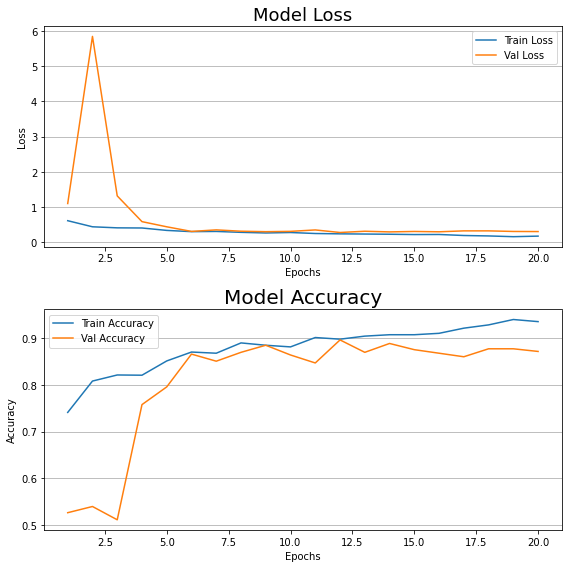

In [125]:
model_performance(hist)

In [126]:
model2.evaluate(x_train, y_train)

66/66 [==============================] - 64s 969ms/step - loss: 0.0911 - accuracy: 0.9649


[0.09111281484365463, 0.9649122953414917]

In [127]:
model2.evaluate(x_val, y_val)

17/17 [==============================] - 16s 953ms/step - loss: 0.3099 - accuracy: 0.8712


[0.309896320104599, 0.8712121248245239]

In [128]:
model2.evaluate(x_test, y_test)

49/49 [==============================] - 49s 991ms/step - loss: 0.2063 - accuracy: 0.9152


[0.20628032088279724, 0.9152215719223022]

# Model 3:

In [139]:
inputs = Input(shape=(img_dims, img_dims, 3))

#1st Convolution
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#2nd Convolution
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#3rd Convolution
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#4th Convolution
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#5th Convolution
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fully Connected layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x) #<--Converting a real value into a interpretable probability

# Creating model and compiling
model3 = Model(inputs=inputs, outputs=output)
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights4.hdf5', save_best_only=True, save_weights_only=True)
#hdf5 (Hierarchical Data Format) is to store the weights of the best performing epoch
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=2, mode='max') #<--Reduce learning rate 
#when the metric has stopped improving.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=20, mode='min')

In [140]:
model3.input.shape

TensorShape([None, 150, 150, 3])

In [141]:
hist = model3.fit(train_generator, epochs=30, validation_data=test_generator,
                  shuffle=True, batch_size = 10, callbacks=[checkpoint, lr_reduce, early_stop])

Epoch 1/30
264/264 [==============================] - 132s 500ms/step - loss: 0.5278 - accuracy: 0.7364 - val_loss: 0.7741 - val_accuracy: 0.4545
Epoch 2/30
264/264 [==============================] - 125s 473ms/step - loss: 0.4935 - accuracy: 0.7755 - val_loss: 0.9108 - val_accuracy: 0.5455
Epoch 3/30
264/264 [==============================] - 121s 456ms/step - loss: 0.4889 - accuracy: 0.7691 - val_loss: 0.5688 - val_accuracy: 0.6848
Epoch 4/30
264/264 [==============================] - 121s 458ms/step - loss: 0.4469 - accuracy: 0.8066 - val_loss: 1.0057 - val_accuracy: 0.4545
Epoch 5/30
264/264 [==============================] - 122s 461ms/step - loss: 0.4780 - accuracy: 0.7827 - val_loss: 0.9599 - val_accuracy: 0.4545
Epoch 6/30
264/264 [==============================] - 125s 473ms/step - loss: 0.4707 - accuracy: 0.7892 - val_loss: 1.1300 - val_accuracy: 0.5682
Epoch 7/30
264/264 [==============================] - 120s 453ms/step - loss: 0.4598 - accuracy: 0.7967 - val_loss: 1.0122 -

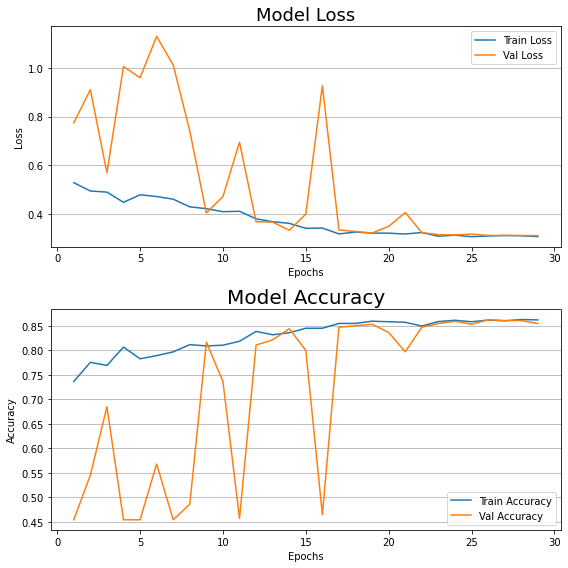

In [142]:
model_performance(hist)

In [145]:
preds = model3.predict(test_generator)

accur = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()
#tp = true positive tn = true negative fp = false positive fn = false negative


print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accur))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train Accuracy: {}'.format(np.round((hist.history["accuracy"][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[302  58]
 [ 38 262]]

TEST METRICS ----------------------
Accuracy: 85.45454545454545%
Precision: 81.875%
Recall: 87.33333333333333%
F1-score: 84.51612903225806

TRAIN METRIC ----------------------
Train Accuracy: 86.2


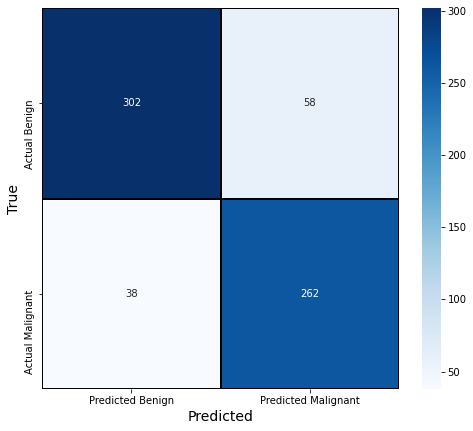

In [146]:
cm = pd.DataFrame(cm, index = ['Actual Benign', 'Actual Malignant'], columns = ['Predicted Benign', 'Predicted Malignant'])
plt.figure(figsize = (8,7))
labels = ['Benign', 'Malignant']
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

# Predict:

In [78]:
image_size = (150, 150)

In [79]:
import keras
import tensorflow as tf
def classify_image(img_path):
    img = keras.preprocessing.image.load_img(
    img_path, target_size= image_size)
    
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model3.predict(img_array)
    result = [np.argmax(element) for element in predictions]
    print(result)
    
    if result == [0]:
        return "Benign"
    elif result == [1]:
        return "Malignant"
  
    else:
        return "None"

# Model 4:

In [ ]:
input_shape = (224,224,3)
lr = 1e-5 # learning rate
epochs = 50
batch_size = 10

# set learning rate reduction
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=1e-7)

model4 = ResNet50(include_top = True, weights = None, input_tensor = None, 
                  input_shape=input_shape, pooling='avg', classes=2)

In [ ]:
model4.compile(optimizer = Adam(lr), loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model4.fit(x_train, y_train, validation_split=0.2, epochs = 20, steps_per_epoch=100,
                               batch_size = batch_size, verbose = 1, callbacks = [lr_reduction])